In [6]:
import tensorflow as tf
# print(tf.test.is_gpu_available())
# !nvidia-smi

In [7]:
import os
import matplotlib.pyplot as plt
import pandas

In [8]:
data_path = "/home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent"
for dirpaths, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpaths}")

There are 2 directories and 0 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent
There are 10 directories and 0 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent/test
There are 0 directories and 250 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent/test/ramen
There are 0 directories and 250 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 files in /home/abdulrahman/Documents/TensorFlow-Developer-Certificate-Guide/10_food_classes_10_

### Data Loaders

In [10]:
# Setup the data inputs.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [12]:
train_dir = os.path.join(data_path,"train")
test_dir = os.path.join(data_path,"test")

In [13]:
IMAGE_SHAPE = (244,244)
BATCH_SIZE = 32

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting Up the CallBacks

Callbacks are extra functionality you can add to your model to be performed during or after the training.

Some of the most Popular callbacks are 

1. Tracking experiments with **TensorBoard** callback
2. Model CheckPointing with **ModelCheckpoint** callback
3. Stopping model from training ( before it trains for too long and overfits ) with **EarlyStopping** callback.

In [14]:
# Create TensorBoard Callback ( Funtionized because we need to create new one for each model )
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log Files to {log_dir}")
    return tensorboard_callback

## Creating Models using Tensorflow hub

In [15]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [37]:
# Let's make a create model function to create a model from URL
def create_model(model_url, num_classes=10):

    # Download the pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                              trainable=False, # Freeze the already learned patterns 
                                              name="feature_extration_layer",
                                              input_shape = IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name="Output_Layer")
    ])

    return model

### Create Resnet Feature Extraction Model

In [38]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [39]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extration_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 Output_Layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [40]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [41]:
resnet_history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(train_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resnet50V2")]
                 )

Saving TensorBoard log Files to tensorflow_hub/resnet50V2/20230911-141759
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9799 - accuracy: 0.3560 - val_loss: 1.2557 - val_accuracy: 0.6523
Epoch 2/5
24/24 [==============================] - 32s 1s/step - loss: 0.9510 - accuracy: 0.7387 - val_loss: 0.8784 - val_accuracy: 0.7305
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 0.6713 - accuracy: 0.8120 - val_loss: 0.7255 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.5150 - accuracy: 0.8640 - val_loss: 0.6850 - val_accuracy: 0.7956
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 0.4238 - accuracy: 0.8893 - val_loss: 0.6558 - val_accuracy: 0.7969


<AxesSubplot:>

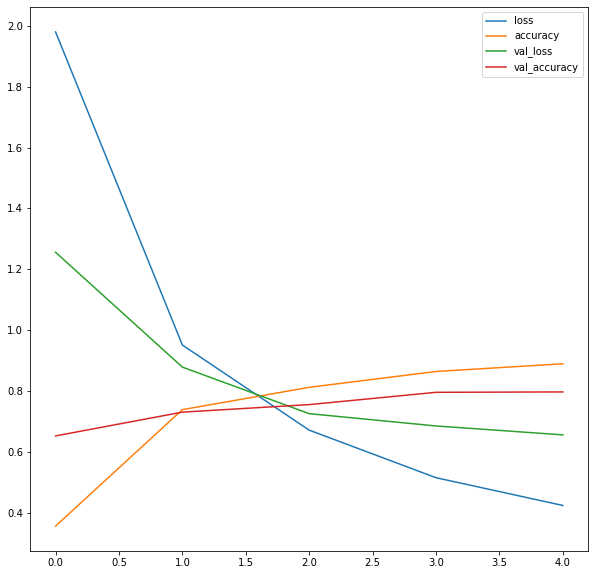

In [43]:
import pandas as pd

pd.DataFrame(resnet_history.history).plot(figsize=(10,10))

In [49]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [50]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [51]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(train_data),
                                              callbacks=[create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving TensorBoard log Files to tensorflow_hub/efficientnetb0/20230911-144414
Epoch 1/10
24/24 [==============================] - 23s 737ms/step - loss: 1.8469 - accuracy: 0.4253 - val_loss: 1.2903 - val_accuracy: 0.7461
Epoch 2/10
24/24 [==============================] - 17s 707ms/step - loss: 1.0690 - accuracy: 0.7920 - val_loss: 0.8511 - val_accuracy: 0.8268
Epoch 3/10
24/24 [==============================] - 17s 708ms/step - loss: 0.7641 - accuracy: 0.8453 - val_loss: 0.7047 - val_accuracy: 0.8307
Epoch 4/10
24/24 [==============================] - 17s 728ms/step - loss: 0.6151 - accuracy: 0.8613 - val_loss: 0.6205 - val_accuracy: 0.8424
Epoch 5/10
24/24 [==============================] - 18s 769ms/step - loss: 0.5220 - accuracy: 0.8880 - val_loss: 0.5309 - val_accuracy: 0.8685
Epoch 6/10
24/24 [==============================] - 18s 777ms/step - loss: 0.4546 - accuracy: 0.9093 - val_loss: 0.5019 - val_accuracy: 0.8815
Epoch 7/10
24/24 [==============================] - 18s 753ms/st

<AxesSubplot:>

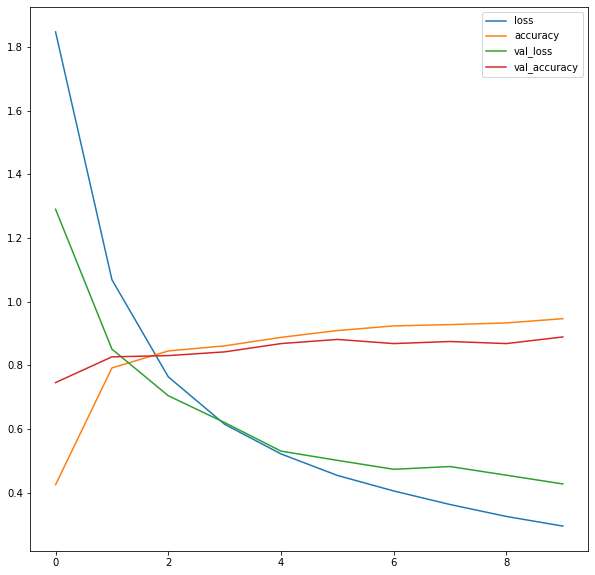

In [53]:
pd.DataFrame(efficientnet_history.history).plot(figsize=(10,10))

In [56]:
# Plot the validation and training curves seperately
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Val Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

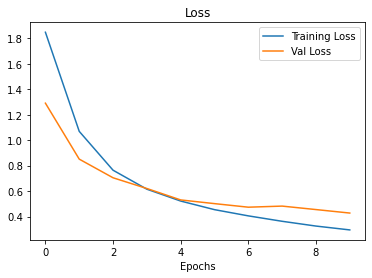

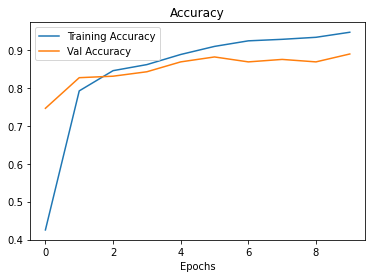

In [57]:
plot_loss_curves(efficientnet_history)

### Comparing our models results using Tensorboard

In [60]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "efficientnet vs resnet model" \
    --description "Comparing two different models" \
    --one_shot

2023-09-11 15:09:35.010841: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 15:09:35.012217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:09:35.052009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:09:35.052365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:09:35.601513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co